# NBA DRAFT

Testing if Git server extension works

# Imports

In [25]:
import pandas as pd

import shap

from sklearn.ensemble import RandomForestClassifier
import random
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
!pip install lightgbm
from lightgbm.sklearn import LGBMClassifier
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Merge and Clean Dataset

In [26]:
df_adv = pd.read_csv("data/NBA 2025 Advanced Stats.csv")
df_adv = df_adv[["Rk", "Player", "PER", "WS/48", "BPM", "VORP▼"]]
df_adv.rename(columns={"VORP▼": "VORP"}, inplace=True) 
df_adv["Player"] = df_adv["Player"].str.strip()
df_adv.head()

# Step 2: Load and combine all draft datasets from 2018 to 2024
dfs_draft = []
for year in range(2018, 2025):
    df_draft = pd.read_csv(f"data/{year} NBA Draft Board.csv")
    df_draft["DraftYear"] = year
    df_draft["Player"] = df_draft["Player"].str.strip()
    dfs_draft.append(df_draft)

df_all_drafts = pd.concat(dfs_draft, ignore_index=True)

# Step 3: Merge on Player name (inner join)
df = pd.merge(df_adv, df_all_drafts, on="Player", how="inner")

# Preview the result
df.head()

,Rk,Player,PER,WS/48,BPM,VORP,Age,Team,League,Pos,...,STL,BLK,TOV,PF,PTS,Height,Weight,Wingspan,DraftPos,DraftYear
0,2,Shai Gilgeous-Alexander,30.7,0.309,11.5,8.9,19,Kentucky,NCAA,G,...,1.6,0.5,2.7,1.7,14.4,76.50,180.0,83.50,11,2018
1,4,Tyrese Haliburton,21.8,0.204,5.8,4.9,20,Iowa State,NCAA,G,...,2.5,0.7,2.8,1.3,15.2,76.75,175.0,79.75,12,2020
2,8,Anthony Edwards,20.1,0.140,4.3,4.6,18,Georgia,NCAA,G,...,1.3,0.6,2.7,2.2,19.1,76.00,225.0,81.00,1,2020
3,11,Luka Dončić,24.1,0.160,6.7,3.9,19,Real Madrid,EuroLeague,G,...,1.1,0.3,2.3,1.5,16.0,78.50,218.0,83.00,3,2018
4,13,Cade Cunningham,20.6,0.115,3.9,3.7,19,Oklahoma State,NCAA,G,...,1.6,0.8,4.0,2.5,20.1,80.00,220.0,84.00,1,2021


In [27]:
print(df.columns)

df = df[['Rk', 'Player', 'PER', 'WS/48', 'BPM', 'VORP', 'Age', 'Team', 'League', 'Pos', 'G', 'MP', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Height', 'Weight', 'Wingspan', 'DraftPos', 'DraftYear']]
df.head()

#For Undrafted Players, assign them with integer 61 to keep ordinal ordering
df['DraftPos'] = df['DraftPos'].replace('Undrafted', 61)
df['DraftPos'] = df['DraftPos'].astype(int)

Index(['Rk', 'Player', 'PER', 'WS/48', 'BPM', 'VORP', 'Age', 'Team', 'League',
       'Pos', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'Height', 'Weight', 'Wingspan', 'DraftPos',
       'DraftYear'],
      dtype='object')


# Code Model

## Split Training and Testing Data

In [28]:
train_df, test_df = train_test_split(df, test_size=0.30, random_state=123)
train_df.head()

,Rk,Player,PER,WS/48,BPM,VORP,Age,Team,League,Pos,...,STL,BLK,TOV,PF,PTS,Height,Weight,Wingspan,DraftPos,DraftYear
190,361,Terrence Shannon Jr.,11.9,0.091,-2.1,0.0,23,Illinois,NCAA,G,...,1.0,0.9,2.0,2.2,23.0,77.75,219.4,80.75,27,2024
89,173,Matisse Thybulle,17.0,0.146,5.0,0.6,22,Washington,NCAA,G,...,3.5,2.3,1.8,2.8,9.1,77.00,195.0,83.50,20,2019
21,45,Dyson Daniels,15.6,0.093,1.5,2.3,19,IGN,G League,G,...,2.0,0.7,2.7,2.2,11.6,78.00,195.2,82.50,8,2022
125,235,Josh Minott,15.5,0.153,2.2,0.3,19,Memphis,NCAA,G,...,0.8,0.7,0.9,1.8,6.6,79.50,205.0,83.75,45,2022
212,403,Jaden Springer,10.7,0.070,-2.7,-0.1,18,Tennessee,NCAA,G,...,1.2,0.4,2.4,2.0,12.5,75.00,202.0,79.75,28,2021


## EDA

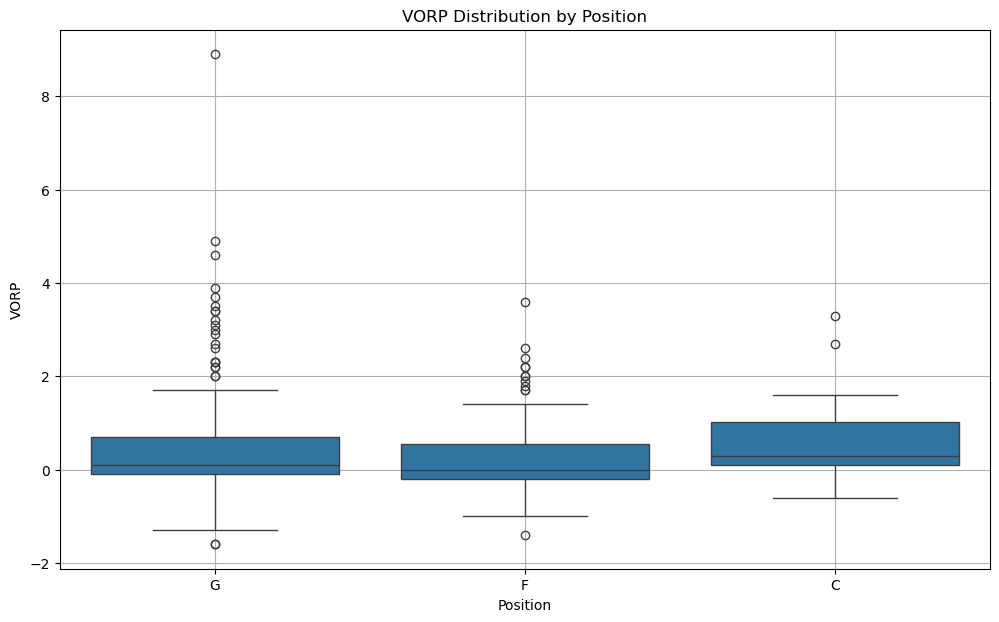

In [29]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Pos', y='VORP')

plt.title('VORP Distribution by Position')
plt.xlabel('Position')
plt.ylabel('VORP')
plt.grid(True)
plt.show()

## Preprocessing and Transformations

In [30]:
print(df.columns)

df.dtypes

Index(['Rk', 'Player', 'PER', 'WS/48', 'BPM', 'VORP', 'Age', 'Team', 'League',
       'Pos', 'G', 'MP', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Height', 'Weight', 'Wingspan', 'DraftPos', 'DraftYear'],
      dtype='object')


Rk             int64
Player        object
PER          float64
WS/48        float64
BPM          float64
VORP         float64
Age            int64
Team          object
League        object
Pos           object
G              int64
MP           float64
eFG%         float64
FT%          float64
TRB          float64
AST          float64
STL          float64
BLK          float64
TOV          float64
PF           float64
PTS          float64
Height       float64
Weight       float64
Wingspan     float64
DraftPos       int64
DraftYear      int64
dtype: object

In [31]:
# Create APE index. The ratio of Wingspan to Height
df['APE'] = df['Wingspan'] / df['Height']

df.dtypes

Rk             int64
Player        object
PER          float64
WS/48        float64
BPM          float64
VORP         float64
Age            int64
Team          object
League        object
Pos           object
G              int64
MP           float64
eFG%         float64
FT%          float64
TRB          float64
AST          float64
STL          float64
BLK          float64
TOV          float64
PF           float64
PTS          float64
Height       float64
Weight       float64
Wingspan     float64
DraftPos       int64
DraftYear      int64
APE          float64
dtype: object

In [32]:
numerical_features = ["Age", "G", "MP", "eFG%", "FT%", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "Weight", "APE", "DraftPos"]

#categorical_features = ["Team", "League", "Pos"]
categorical_features = ["Pos"]

#drop_features = ["Player", "DraftYear", "PER", "WS/48", "BPM", 'Rk']
drop_features = ["Player", "DraftYear", "PER", "WS/48", "VORP", 'Rk', "Team", "League", 'Height', 'Wingspan']

#target = ["Rk"]

In [33]:
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')

preprocessor = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features), 
    ('drop', drop_features),
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'G', 'MP', 'eFG%', 'FT%', 'TRB', 'AST',
                                  'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Weight',
                                  'APE', 'DraftPos']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Pos']),
                                ('drop', 'drop',
                                 ['Player', 'DraftYear', 'PER', 'WS/48', 'VORP',
                                  'Rk', 'Team', 'League', 'Height',
                                  'Wingspan'])])

## Split Training and Test Sets

In [34]:
train_df, test_df = train_test_split(df, test_size=0.30, random_state=123)
train_df.head()

#VORP
#X_train = train_df.drop(['VORP'], axis = 1)
#y_train = train_df['VORP']
#X_test = test_df.drop(['VORP'], axis = 1)
#y_test = test_df['VORP']

#BPM
X_train = train_df.drop(['BPM'], axis = 1)
y_train = train_df['BPM']
X_test = test_df.drop(['BPM'], axis = 1)
y_test = test_df['BPM']

In [35]:
X_train.head()

,Rk,Player,PER,WS/48,VORP,Age,Team,League,Pos,G,...,BLK,TOV,PF,PTS,Height,Weight,Wingspan,DraftPos,DraftYear,APE
190,361,Terrence Shannon Jr.,11.9,0.091,0.0,23,Illinois,NCAA,G,32,...,0.9,2.0,2.2,23.0,77.75,219.4,80.75,27,2024,1.038585
89,173,Matisse Thybulle,17.0,0.146,0.6,22,Washington,NCAA,G,36,...,2.3,1.8,2.8,9.1,77.00,195.0,83.50,20,2019,1.084416
21,45,Dyson Daniels,15.6,0.093,2.3,19,IGN,G League,G,29,...,0.7,2.7,2.2,11.6,78.00,195.2,82.50,8,2022,1.057692
125,235,Josh Minott,15.5,0.153,0.3,19,Memphis,NCAA,G,33,...,0.7,0.9,1.8,6.6,79.50,205.0,83.75,45,2022,1.053459
212,403,Jaden Springer,10.7,0.070,-0.1,18,Tennessee,NCAA,G,25,...,0.4,2.4,2.0,12.5,75.00,202.0,79.75,28,2021,1.063333


## LASSO

In [36]:
# Create Model pipeline
pipe_lasso = make_pipeline(preprocessor, Lasso(max_iter=10000))

# Specify Param Grid
param_grid_lasso = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Grid Search CV
grid_search_lasso = GridSearchCV(
    pipe_lasso,
    param_grid=param_grid_lasso,
    scoring='neg_root_mean_squared_error',
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# Fit Model
grid_search_lasso.fit(X_train, y_train)

# View Results
lasso_df_sorted = pd.DataFrame(grid_search_lasso.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "mean_fit_time",
        'param_lasso__alpha'
    ]
].sort_values(
    by=["mean_test_score"],
    ascending=False
).T

In [37]:
lasso_df_sorted

,3,2,1,0,4,5,6
mean_test_score,-3.452458,-3.516786,-3.529020,-3.530422,-3.631147,-3.643314,-3.643314
std_test_score,0.353711,0.328850,0.326171,0.325906,0.342557,0.339815,0.339815
mean_fit_time,0.013479,0.018130,0.017060,0.018254,0.010634,0.011290,0.012838
param_lasso__alpha,0.100000,0.010000,0.001000,0.000100,1.000000,10.000000,100.000000


## Ridge

In [38]:
# Create Model pipeline
pipe_ridge = make_pipeline(preprocessor, Ridge(max_iter=10000))

# Specify Param Grid
param_grid_ridge = {
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Grid Search CV
grid_search_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# Fit Model
grid_search_ridge.fit(X_train, y_train)

# View Results
ridge_df_sorted = pd.DataFrame(grid_search_ridge.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "mean_fit_time",
        'param_ridge__alpha'
    ]
].sort_values(
    by=["mean_test_score"],
    ascending=False
).T

In [39]:
ridge_df_sorted

,6,5,4,3,2,1,0
mean_test_score,-3.461501,-3.503929,-3.526880,-3.530188,-3.530537,-3.530572,-3.530575
std_test_score,0.375735,0.342386,0.328175,0.326118,0.325901,0.325879,0.325877
mean_fit_time,0.007554,0.009143,0.009646,0.040312,0.035019,0.032363,0.028787
param_ridge__alpha,100.000000,10.000000,1.000000,0.100000,0.010000,0.001000,0.000100


## KNN

In [50]:
# Create Model pipeline
pipe_knn = make_pipeline(
    preprocessor, KNeighborsRegressor()
)

# Specify Param Grid
param_grid_knn = {
    "kneighborsregressor__n_neighbors": [1,2,3,4, 5, 10, 25, 50, 100, 200],
    "kneighborsregressor__weights": ['distance', "uniform"]}

# Grid Search CV
grid_search_knn = GridSearchCV(
    pipe_knn,
    param_grid=param_grid_knn,
    scoring='neg_root_mean_squared_error',
    refit=True,
    n_jobs=-1,
    return_train_score=True
)


# Fit Model
grid_search_knn.fit(X_train, y_train)

# View Results
knn_df_sorted = pd.DataFrame(grid_search_knn.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "mean_fit_time",
        'param_kneighborsregressor__n_neighbors',
        'param_kneighborsregressor__weights'
    ]
].sort_values(
    by=["mean_test_score"],  # Sorting by mean_test_score, as this matches the column name
    ascending=False
).T



C:\Users\Kevin\anaconda3\envs\dataprojects\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-5.01217449 -5.01217449 -4.26178751 -4.24021549 -3.93234927 -3.90823225
 -3.79819192 -3.78131297 -3.69970028 -3.68056749 -3.59751456 -3.59071491
 -3.50177779 -3.50109247 -3.53316342 -3.53945187 -3.5728428  -3.58347788
         nan         nan]
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\dataprojects\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [-4.74089005e-17  0.00000000e+00 -7.15999976e-08 -2.37350706e+00
 -1.17789633e-07 -2.70000157e+00 -1.62192264e-07 -2.91436579e+00
 -2.01366113e-07 -2.99902460e+00 -3.92154261e-07 -3.23973986e+00
 -9.04155717e-07 -3.37907971e+00 -1.66380615e-06 -3.47287895e+00
 -3.01060246e-06 -3.52034963e+00             nan             nan]
  warnings.warn(


In [51]:
knn_df_sorted

,13,12,14,15,16,17,11,10,9,8,7,6,5,4,3,2,1,0,18,19
mean_test_score,-3.501092,-3.501778,-3.533163,-3.539452,-3.572843,-3.583478,-3.590715,-3.597515,-3.680567,-3.6997,-3.781313,-3.798192,-3.908232,-3.932349,-4.240215,-4.261788,-5.012174,-5.012174,NaN,NaN
std_test_score,0.381276,0.37781,0.373127,0.374113,0.337732,0.334149,0.308472,0.305951,0.254929,0.252752,0.292293,0.288294,0.277101,0.269961,0.324027,0.308595,0.421028,0.421028,NaN,NaN
mean_fit_time,0.008665,0.008501,0.008487,0.008593,0.009491,0.008657,0.007985,0.005948,0.00818,0.009041,0.009432,0.009392,0.010697,0.009174,0.010643,0.010476,0.010831,0.01226,0.009144,0.009003
param_kneighborsregressor__n_neighbors,25,25,50,50,100,100,10,10,5,5,4,4,3,3,2,2,1,1,200,200
param_kneighborsregressor__weights,uniform,distance,distance,uniform,distance,uniform,uniform,distance,uniform,distance,uniform,distance,uniform,distance,uniform,distance,uniform,distance,distance,uniform


## XG Boost Regressor

In [42]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Create Model pipeline
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=123, objective='reg:squarederror')
)

# Specify Param Grid
param_grid_xgb = {
    "xgbregressor__n_estimators": [50, 100, 200],
    "xgbregressor__max_depth": [3, 5, 10],
    "xgbregressor__learning_rate": [0.01, 0.05, 0.1],
    "xgbregressor__subsample": [0.6, 0.8, 1.0],
    "xgbregressor__colsample_bytree": [0.6, 0.8, 1.0]
}

# Grid Search CV
grid_search_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid_xgb,
    scoring='neg_root_mean_squared_error',
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# Fit Model
grid_search_xgb.fit(X_train, y_train)

# View Results
xgb_df_sorted = pd.DataFrame(grid_search_xgb.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "mean_fit_time",
        'param_xgbregressor__n_estimators',
        'param_xgbregressor__max_depth',
        'param_xgbregressor__learning_rate',
        'param_xgbregressor__subsample',
        'param_xgbregressor__colsample_bytree'
    ]
].sort_values(
    by=["mean_test_score"],
    ascending=False
).T

In [43]:
xgb_df_sorted

,84,87,165,86,166,85,5,174,183,164,...,78,209,143,141,236,239,242,222,212,215
mean_test_score,-3.508256,-3.511298,-3.511546,-3.515366,-3.516353,-3.517561,-3.517980,-3.522334,-3.525311,-3.526953,...,-3.878330,-3.898582,-3.912318,-3.918100,-3.921312,-3.957931,-3.959156,-3.959255,-3.970462,-4.006872
std_test_score,0.373853,0.385515,0.380650,0.374620,0.372786,0.384689,0.377918,0.386972,0.365554,0.365066,...,0.386105,0.507151,0.487828,0.387210,0.498659,0.491052,0.492632,0.393353,0.509083,0.498297
mean_fit_time,0.040217,0.048517,0.036238,0.031639,0.036697,0.042001,0.016285,0.065187,0.741494,0.023790,...,0.252560,0.120818,0.057164,0.371862,0.113936,0.433714,0.269974,0.290378,1.019733,0.381421
param_xgbregressor__n_estimators,100.000000,200.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,50.000000,...,200.000000,50.000000,200.000000,200.000000,50.000000,100.000000,200.000000,200.000000,100.000000,200.000000
param_xgbregressor__max_depth,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,10.000000,3.000000,...,10.000000,10.000000,3.000000,3.000000,10.000000,10.000000,10.000000,3.000000,10.000000,10.000000
param_xgbregressor__learning_rate,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.100000,0.050000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.050000,0.050000
param_xgbregressor__subsample,0.600000,0.600000,0.600000,1.000000,0.800000,0.800000,1.000000,0.600000,0.600000,1.000000,...,0.600000,1.000000,1.000000,0.600000,1.000000,1.000000,1.000000,0.600000,1.000000,1.000000
param_xgbregressor__colsample_bytree,0.800000,0.800000,1.000000,0.800000,1.000000,0.800000,0.600000,1.000000,1.000000,1.000000,...,0.600000,1.000000,0.800000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Random Forest Regressor

In [44]:
# Create Model pipeline
pipe_rf = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=123)
)

# Specify Param Grid
param_grid_rf = {
    "randomforestregressor__n_estimators": [3, 5, 10, 15, 20, 50, 75, 100],
    "randomforestregressor__max_depth": [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "randomforestregressor__min_samples_split": [2, 5, 10]
}

# Grid Search CV
grid_search_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    refit=True,
    n_jobs=-1,
    return_train_score=True
)

# Fit Model
grid_search_rf.fit(X_train, y_train)

# View Results
rf_df_sorted = pd.DataFrame(grid_search_rf.cv_results_)[
    [
        "mean_test_score",
        "std_test_score",
        "mean_fit_time",
        'param_randomforestregressor__n_estimators',
        'param_randomforestregressor__max_depth',
        'param_randomforestregressor__min_samples_split'
    ]
].sort_values(
    by=["mean_test_score"],
    ascending=False
).T

In [45]:
rf_df_sorted

,30,31,22,6,14,29,78,270,150,174,...,224,216,168,144,192,120,240,96,72,264
mean_test_score,-3.529215,-3.532060,-3.547792,-3.547792,-3.547792,-3.547908,-3.548584,-3.549829,-3.549829,-3.549829,...,-4.077935,-4.269383,-4.269383,-4.269383,-4.269383,-4.269383,-4.269383,-4.269383,-4.269383,-4.269383
std_test_score,0.359164,0.374865,0.348864,0.348864,0.348864,0.378136,0.350538,0.349699,0.349699,0.349699,...,0.477141,0.469117,0.469117,0.469117,0.469117,0.469117,0.469117,0.469117,0.469117,0.469117
mean_fit_time,0.497866,2.752607,0.096396,0.097511,0.098943,0.091577,0.182696,1.324067,1.022471,0.972161,...,0.098991,0.079161,0.015264,0.058099,0.119578,0.014522,0.052935,0.081215,0.040738,0.015525
param_randomforestregressor__n_estimators,75.000000,100.000000,75.000000,75.000000,75.000000,50.000000,75.000000,75.000000,75.000000,75.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
param_randomforestregressor__max_depth,5.000000,5.000000,1.000000,1.000000,1.000000,5.000000,20.000000,100.000000,50.000000,60.000000,...,80.000000,80.000000,60.000000,50.000000,70.000000,40.000000,90.000000,30.000000,20.000000,100.000000
param_randomforestregressor__min_samples_split,2.000000,2.000000,10.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [46]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 75}
-3.5292147651581267


In [47]:
# Convert cv_results_ to DataFrame
rf_results = pd.DataFrame(grid_search_rf.cv_results_)

# Get the row with the highest mean_test_score
best_row = rf_results.loc[rf_results['mean_test_score'].idxmax()]

print(best_row)

mean_fit_time                                                                              0.497866
std_fit_time                                                                               0.728646
mean_score_time                                                                            0.130544
std_score_time                                                                             0.234723
param_randomforestregressor__max_depth                                                            5
param_randomforestregressor__min_samples_split                                                    2
param_randomforestregressor__n_estimators                                                        75
params                                            {'randomforestregressor__max_depth': 5, 'rando...
split0_test_score                                                                         -3.098883
split1_test_score                                                                         -3.400494


## Feature Importances

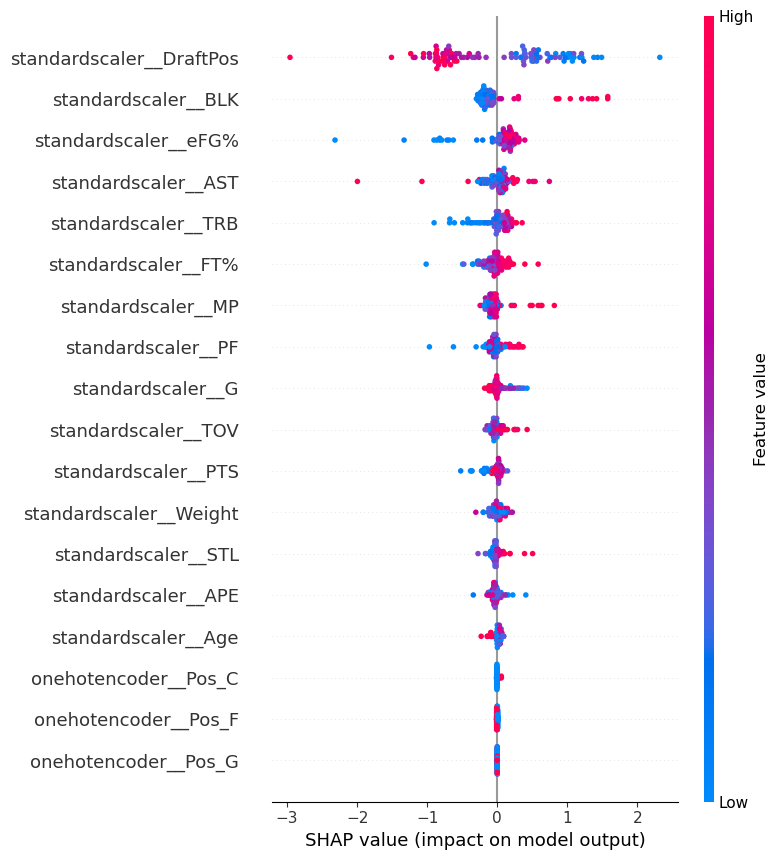

In [48]:
# 1. Extract the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# 2. Get the transformed training data
X_transformed = best_rf_model.named_steps['columntransformer'].transform(X_train)

# 3. Get transformed feature names
feature_names = best_rf_model.named_steps['columntransformer'].get_feature_names_out()

# 4. SHAP Explainer for Random Forest
explainer = shap.TreeExplainer(best_rf_model.named_steps['randomforestregressor'])

# 5. Calculate SHAP values on a sample (you can use [:100] for speed)
shap_values = explainer.shap_values(X_transformed[:100])

# 6. SHAP Summary Plot
shap.summary_plot(shap_values, X_transformed[:100], feature_names=feature_names)

## Test Model on Unseen Data

# References

Basketball Reference

Sports Reference

NBADraft.net